In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/xgi/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [30]:
def generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes,
                                      edge_probability_core, edge_probability_periphery,
                                      avg_edge_size, core_periphery_probability):
    """
    This function generates a random hypergraph with a core-periphery structure and creates its binary incidence matrix.

    Args:
      num_core_nodes: Number of nodes in the core.
      num_periphery_nodes: Number of nodes in the periphery.
      edge_probability_core: Probability of an edge forming between core nodes.
      edge_probability_periphery: Probability of an edge forming between periphery nodes.
      avg_edge_size: Average number of nodes per edge.
      core_periphery_probability: Probability of an edge forming between a core node and a periphery node.

    Returns:
      A tuple containing four elements:
          * core_nodes: List of core nodes.
          * periphery_nodes: List of periphery nodes.
          * edges: List of edges.
          * incidence_matrix: Binary incidence matrix as a NumPy array.
    """
    import numpy as np

    # Define core and periphery nodes
    core_nodes = list(range(num_core_nodes))
    periphery_nodes = list(range(num_core_nodes, num_core_nodes + num_periphery_nodes))

    # Get total number of nodes
    total_nodes = len(core_nodes) + len(periphery_nodes)

    # Generate edges
    edges = []
    for _ in range(int(len(core_nodes) * edge_probability_core)):
        # Sample core nodes for an edge
        edge = random.sample(core_nodes, k=int(avg_edge_size))
        edges.append(edge)

    for _ in range(int(len(periphery_nodes) * edge_probability_periphery)):
        # Sample periphery nodes for an edge
        edge = random.sample(periphery_nodes, k=int(avg_edge_size))
        edges.append(edge)

    # Add edges between core and periphery nodes
    for _ in range(int(num_core_nodes * num_periphery_nodes * core_periphery_probability)):
        # Sample a core node and a periphery node
        core_node = random.choice(core_nodes)
        periphery_node = random.choice(periphery_nodes)
        # Create an edge with the core and periphery node
        edge = [core_node, periphery_node]
        # Optionally, you can sample additional nodes for the edge
        if avg_edge_size > 2:
            additional_nodes = random.sample(core_nodes + periphery_nodes, k=int(avg_edge_size) - 2)
            edge.extend(additional_nodes)
            
        edges.append(edge)

    # Create empty matrix
    incidence_matrix = np.zeros((total_nodes, len(edges)), dtype=int)

    # Fill the matrix with 1s for corresponding nodes in each edge
    for i, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node, i] = 1

    return core_nodes, periphery_nodes, edges, incidence_matrix

# Example usage
num_core_nodes = 4
num_periphery_nodes = 15
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
print(f"Min Order: {np.min(H.sum(axis=0))}")
H

H.shape=(19, 10)
Min Order: 2


,0,1,2,3,4,5,6,7,8,9
0,1,0,1,0,0,1,0,1,1,1
1,1,1,1,0,0,0,0,0,0,0
2,1,1,0,0,1,1,0,0,0,0
3,0,1,1,0,1,0,1,0,1,0
4,0,0,0,0,0,1,0,0,0,0
5,0,0,0,1,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0,0,0,0


# Plot the Hypergraphs

Text(0.5, 0, 'Hyperedges')

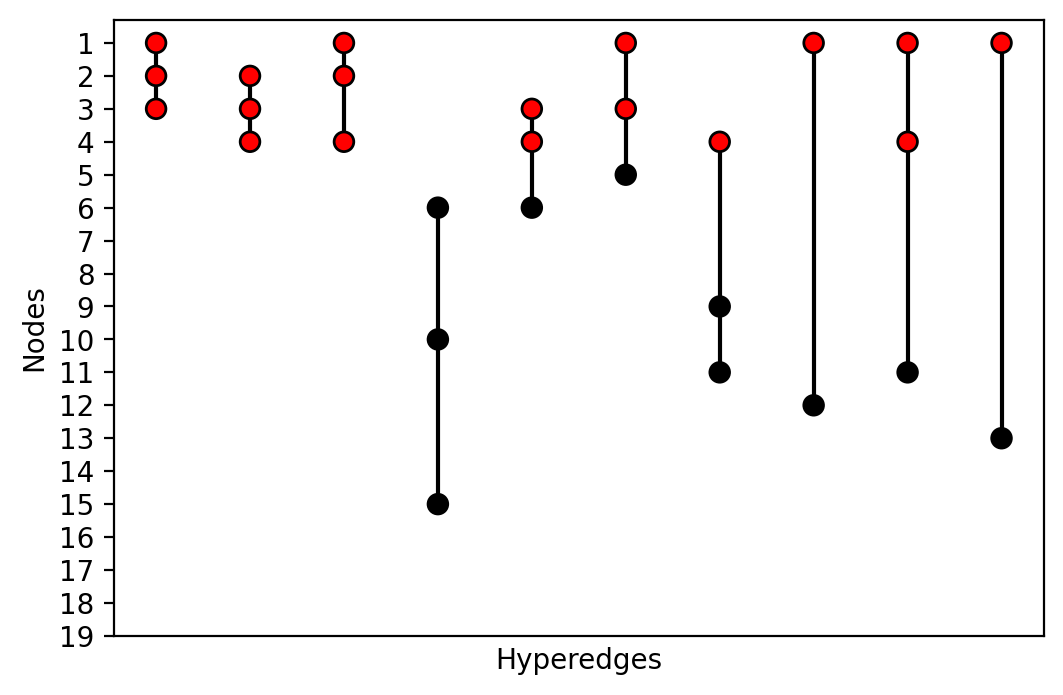

In [31]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

for i, column in enumerate(H.columns):
    hyperedge = H[column][H[column] > 0]
    order = len(hyperedge)
    x_ind = np.ones(order) * (i + 1)
    
    c = np.where(hyperedge.index.isin(core_nodes), 'r', 'k')

    # Plot nodes
    plt.scatter(x_ind, 
                hyperedge.index, 
                s=50,
                c=c, 
                ec='k',
                zorder=3)

    # Plot edges
    plt.plot(x_ind, 
             hyperedge.index,
             c='k') 
    
plt.yticks(H.index, H.index + 1)
plt.xticks([])
plt.gca().invert_yaxis()
plt.ylabel('Nodes')
plt.xlabel('Hyperedges')

# clique expansion

Text(0.5, 73.44444444444441, 'Nodes')

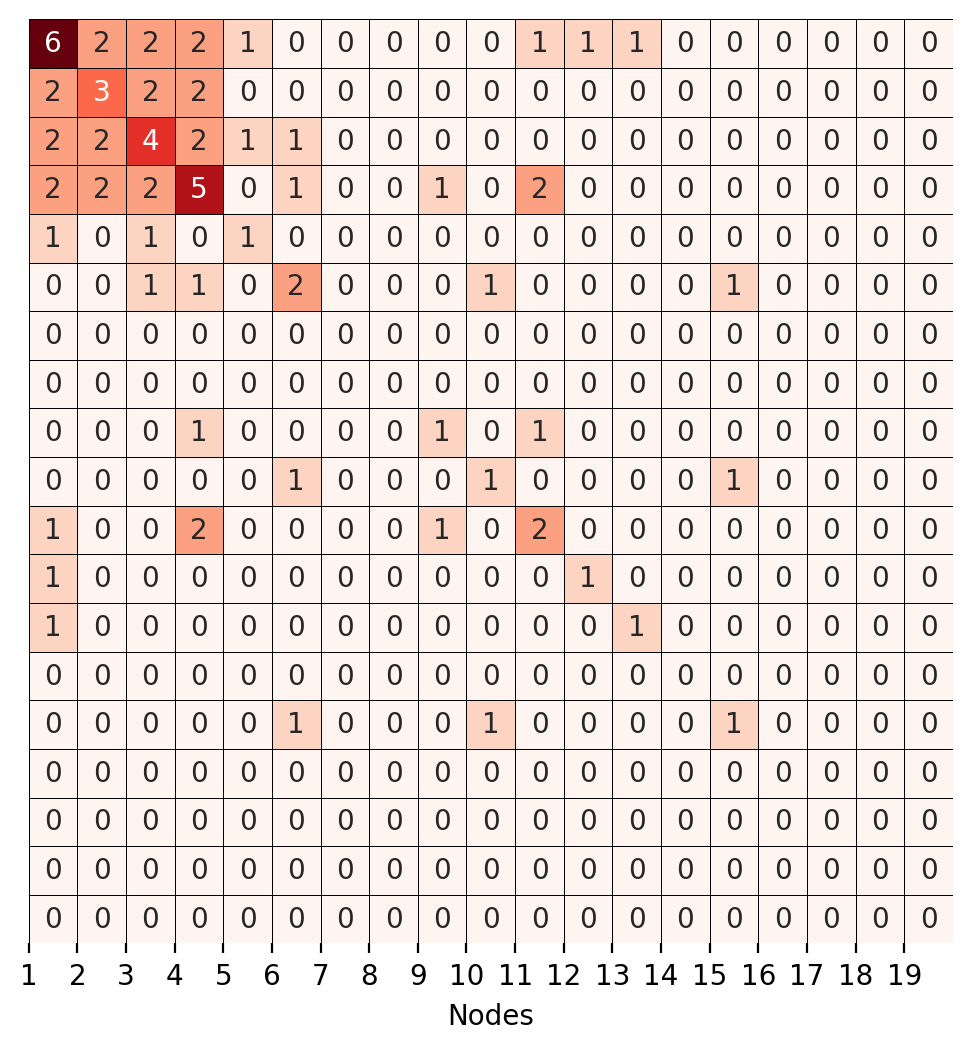

In [32]:
A = matrix.clique_expand_incidence(H, zero_diag=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    A,
    square=True,
    lw=0.25,
    cbar=False,
    annot=True,
    linecolor='k',
    cmap='Reds',
)

plt.yticks([])
plt.xticks(H.index, H.index + 1)
plt.xlabel('Nodes')

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Hypergraph plotting

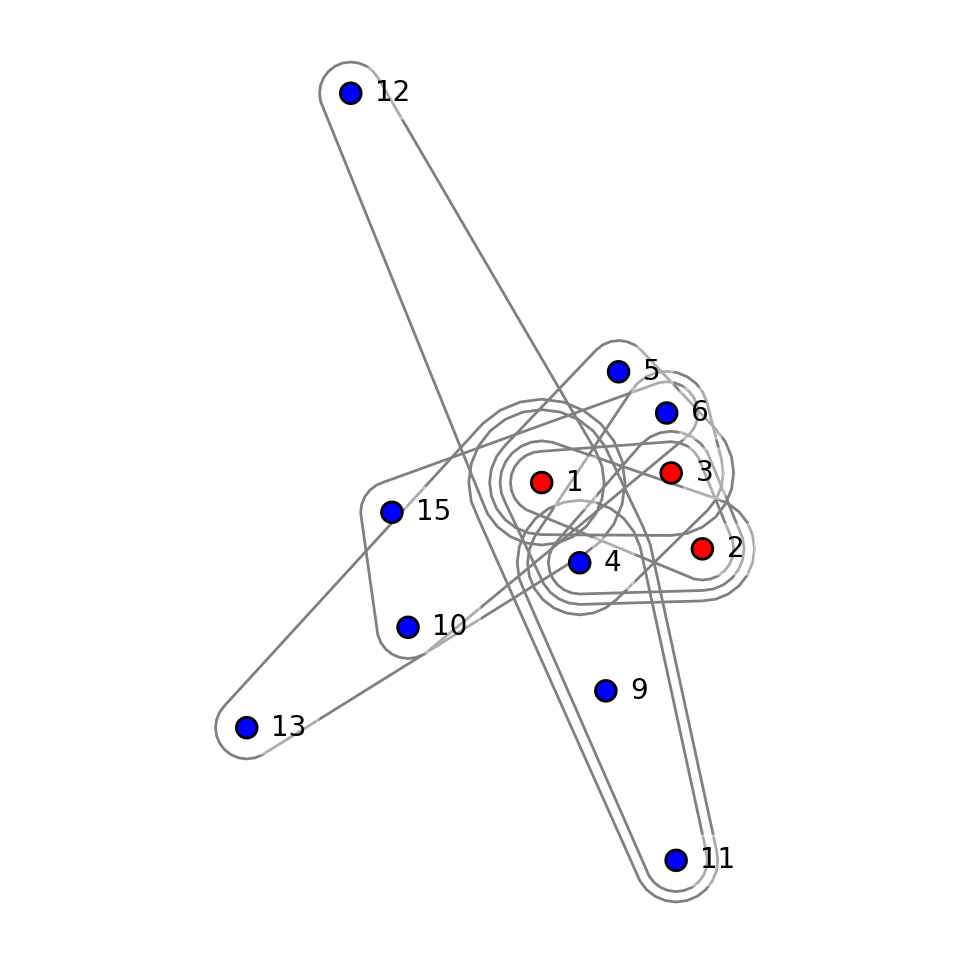

In [34]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx+1] = tuple(row[row == 1].index +1)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=True,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )


# Compute nonlinear node centrality

In [35]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)
nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)

nodes = nodes.sort_values(by='centrality', 
                          ascending=False,)
nodes.head()

,node,centrality,core
0,0,0.231263,True
3,3,0.210444,True
2,2,0.173268,True
1,1,0.148479,True
10,10,0.073219,False


In [36]:
edges = pd.DataFrame({
    'edge' : H.columns.to_list(),
    'centrality' : ecent,
})

core_edges = np.where(H.iloc[core_nodes, :].any() == 1)[0]

edges['core'] = edges['edge'].isin(core_edges)

edges = edges.sort_values(by='centrality', 
                          ascending=False,)
edges.head(10)

,edge,centrality,core
2,2,0.150160,True
0,0,0.140701,True
1,1,0.135404,True
8,8,0.131011,True
5,5,0.112932,True
4,4,0.108393,True
6,6,0.079190,True
7,7,0.064561,True
9,9,0.064561,True
3,3,0.013085,False


# Plot centralities

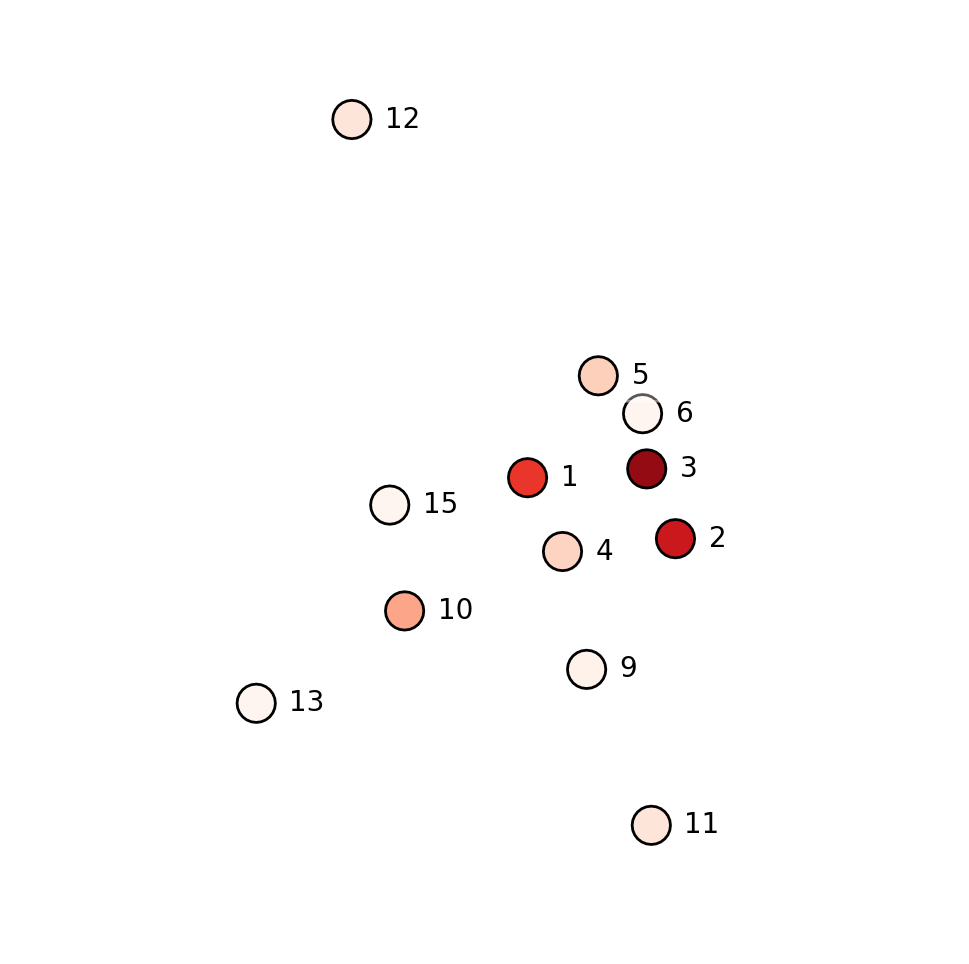

In [37]:
colors = plt2.floats_to_colors(ncent, colormap='Reds')

def node_color(v):
    return colors[v, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=True,
                 node_radius=2,
                 nodes_kwargs={'color': node_color, 'ec' : 'k'},
                 edges_kwargs={'edgecolors': 'w',},
                 layout_kwargs = {'seed': 39},
                )

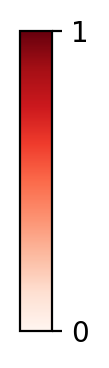

In [38]:
reload(plt2)
plt2.make_colorbar(cmap='Reds')

In [ ]:
colors = plt2.floats_to_colors(ecent, colormap='viridis')

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

def edge_color(v):
    return colors[v, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'ec' : 'k'},
                 edges_kwargs={'edgecolors': 'k', 
                               'linewidths' : 1, 
                               'facecolors': edge_color, 
                               'alpha' : 0.25},
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
reload(plt2)
plt2.make_colorbar()

# Is there a principaled way to "discover" this threshold?

In [ ]:
"""choosing from node centralities only"""

n_bins = 20
res = []

for n_t in np.linspace(0, 1, n_bins):
    node_idx = np.argwhere(ncent >= n_t).ravel()
    core = H.iloc[node_idx]
    
    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

                
    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None

    row = {
        'node_thresh' : n_t,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
            
    
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res,
             x='node_thresh',
             y='fiedler_number')

max_value_row = res.loc[res['fiedler_number'].idxmax()]

plt.scatter(
    max_value_row['node_thresh'],
    max_value_row['fiedler_number'],
    c='r',
    ec='k',
    zorder=5,
)

plt.ylabel('Core Fiedler Number')
plt.xlabel('Node Centrality Threshold')

# sparse hypergraph with core periphery structure

In [ ]:

# Example usage
num_core_nodes = 3
num_periphery_nodes = 15
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.25

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
H.head()

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={
                     'edgecolors': 'k', 
                     'lw' : 1, 
                     'facecolors': edge_color, 
                     'alpha' : 0.15,
                 },
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={
                     'edgecolors': edge_color, 
                     'lw' : 1, 
                 },
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
break

In [ ]:
"""Choosing from both thresholds """

print(f"{H.shape=}")

res = []

for n_t in ncent:
    node_idx = np.argwhere(ncent >= n_t).ravel()
    
    for e_t in ecent:
        edge_idx = np.argwhere(ecent >= e_t).ravel()
        core = H.iloc[node_idx][edge_idx]
        
        if core.empty:
            continue
        
        try:
            L = matrix.normalized_hypergraph_laplacian(core).todense()        
            eigenvalues, eigenvectors = np.linalg.eigh(L)
            fiedler_number = eigenvalues[1]
        except:
            fiedler_number = None
        
        row = {
            'node_thresh' : n_t,
            'edge_thresh' : e_t,
            'n_nodes' : len(node_idx),
            'n_edges' : len(edge_idx),
            'core_nodes' : node_idx,
            'core_edges' : edge_idx,
            'fiedler_number' : fiedler_number,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
res[(res['n_nodes'] == 4) & (res['n_edges'] == 3)]

In [ ]:
res[(res['node_thresh'] > 0.102)  & (res['edge_thresh'] > 0.147)]

In [ ]:
break

# Archive

In [ ]:
# def plot_core_periphery_networkx(core_nodes, periphery_nodes, edges):
#     """
#     This function plots a core-periphery network using NetworkX for layout and Matplotlib for visualization.

#     Args:
#       core_nodes: List of core nodes.
#       periphery_nodes: List of periphery nodes.
#       edges: List of lists, where each inner list represents an edge in the hypergraph.
#     """
#     plt.figure(figsize=(8, 6))

#     # Create a NetworkX graph
#     G = nx.Graph()

#     # Add nodes with color distinction for core and periphery
#     G.add_nodes_from(core_nodes, color='red')
#     G.add_nodes_from(periphery_nodes, color='blue')

#     # Add edges
#     for edge in edges:
#         for i in range(len(edge) - 1):
#             G.add_edge(edge[i], edge[i + 1])

#     # Use a layout algorithm for node positioning (adjust as needed)
#     pos = nx.spring_layout(G)

#     # Draw the graph with node colors and positions
#     nx.draw_networkx_nodes(G, pos, nodelist=periphery_nodes, node_color='blue', node_size=150, edgecolors='k')
#     nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='red', node_size=350, edgecolors='k')
#     nx.draw_networkx_edges(G, pos, alpha=0.7, width=1.5)

#     # Labels and title
#     plt.axis('off')
#     plt.show()
    
# plt.rcParams['figure.dpi'] = 200
# plot_core_periphery_networkx(core_nodes, periphery_nodes, edges)

In [ ]:
break